In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.models import resnet50
from scipy import stats
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from examples.models.initializer import initialize_torchvision_model
from suitability.datasets.dollarstreet import DollarStreetDataset, get_dollarstreet
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter.sample_signals import ConfidenceSignal, LogitSignal, DecisionBoundarySignal, TrainingDynamicsSignal, CorrectnessSignal
import suitability.filter.tests as ftests
from suitability.filter.margin_tuning import tune_margin

import importlib
importlib.reload(ftests)

random.seed(32)
np.random.seed(32)

### Calculate Signals

In [2]:
def remove_prefix_from_state_dict(state_dict, prefix='model.'):
    """
    Remove the prefix from the keys in state_dict if it exists.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [3]:
root_dir = '/mfsnic/u/apouget/data/'
dataset_name = 'fmow'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(torch.load(f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth")['algorithm'])
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Determine data splits
REGIONS = ['Asia', 'Europe', 'Africa', 'Americas', 'Oceania']

# Construct suitability filter
confidences = {}
logits = {}
correctness = {}

for region in REGIONS:
    data = get_wilds_dataset(dataset_name, root_dir, 'test', batch_size=64, shuffle=False, num_workers=4, pre_filter={'region': region})

    signal = ConfidenceSignal(model, device)
    conf = signal.evaluate(data)
    confidences[region] = conf

    signal = CorrectnessSignal(model, device)
    corr = signal.evaluate(data)
    correctness[region] = corr

    signal = LogitSignal(model, device)
    logit = signal.evaluate(data)
    logits[region] = logit
    
    print(f'Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct')

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Region Asia: 55.35% correct
Region Europe: 56.16% correct
Region Africa: 32.78% correct
Region Americas: 56.72% correct
Region Oceania: 59.46% correct


### Statistical Testing & Margin Tuning

In [8]:
eval_data = get_wilds_dataset(dataset_name, root_dir, 'val', batch_size=64, shuffle=False, num_workers=4, pre_filter={'region': 'Europe'})
tuning_data = get_wilds_dataset(dataset_name, root_dir, 'val', batch_size=64, shuffle=False, num_workers=4, pre_filter={'region': 'Americas'})
model.load_state_dict(state_dict)
model.to(device)
test_fn = ftests.non_inferiority_ttest

signal = ConfidenceSignal(model, device)
conf = signal.evaluate(tuning_data)
bm_conf = signal.evaluate(eval_data)
s2 = CorrectnessSignal(model, device)
corr = s2.evaluate(tuning_data)
conf_margin = tune_margin(corr, conf, bm_conf, test_fn, 0.56, delta_x=0.1, initial_m=0.07, delta_m=0.001, accuracy_threshold=0.05, max_iters=100, subsample_size=500)
print(f'Confidence margin: {conf_margin}')

signal = LogitSignal(model, device)
log = signal.evaluate(tuning_data)
bm_log = signal.evaluate(eval_data)
s2 = CorrectnessSignal(model, device)
corr = s2.evaluate(tuning_data)
log_margin = tune_margin(corr, log, bm_log, test_fn, 0.56, delta_x=0.1, initial_m=0.19, delta_m=0.001, accuracy_threshold=0.05, max_iters=100, subsample_size=500)
print(f'Logit margin: {log_margin}')

Iteration 0: Accuracy 0.478 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.069.
Iteration 1: Accuracy 0.524 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.068.
Iteration 2: Accuracy 0.542 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.067.
Iteration 3: Accuracy 0.558 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.066.
Iteration 4: Accuracy 0.548 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.065.
Iteration 5: Accuracy 0.504 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.064.
Iteration 6: Accuracy 0.552 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.063.
Iteration 7: Accuracy 0.486 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.062.
Iteration 8: Accuracy 0.492 < 0.56, but p-value 0.006 <= 0.05. Decreasing m to 0.061.
Iteration 9: Accuracy 0.482 < 0.56, but p-value 0.000 <= 0.05. Decreasing m to 0.060.
Iteration 10: Accuracy 0.492 < 0.56, but p-value 0.013 <= 0.05. Decreasing m to 0.059.
Iteration 11: Accuracy 0.544 < 0.56, but p-value 0.00

In [18]:
test_fn = ftests.non_inferiority_ttest

for region in REGIONS:
    conf = test_fn(bm_conf, confidences[region], margin=conf_margin)
    log = test_fn(bm_log, logits[region], margin=log_margin)
    print(f'EU vs {region} confidences:', conf)
    print(f'EU vs {region} logits:', log)
    hmp = 1/(1/conf['p_value'] + 1/log['p_value'])
    print(f'EU vs {region} (with accuracy {np.mean(correctness[region]) * 100:.2f}) overall: {hmp:.2e}', '--> SUITABLE!' if hmp < 0.05 else '--> NOT SUITABLE!')

EU vs Asia confidences: {'t_statistic': -2.8000298587757815, 'p_value': 0.00255972025818171, 'reject_null': True}
EU vs Asia logits: {'t_statistic': -0.5317893826501235, 'p_value': 0.297441345322349, 'reject_null': False}
EU vs Asia (with accuracy 55.35) overall: 2.54e-03 --> SUITABLE!
EU vs Europe confidences: {'t_statistic': -3.922327287149032, 'p_value': 4.4088820973797674e-05, 'reject_null': True}
EU vs Europe logits: {'t_statistic': -3.2663912577161165, 'p_value': 0.000546085440238711, 'reject_null': True}
EU vs Europe (with accuracy 56.16) overall: 4.08e-05 --> SUITABLE!
EU vs Africa confidences: {'t_statistic': 8.135073368739606, 'p_value': 0.9999999999999998, 'reject_null': False}
EU vs Africa logits: {'t_statistic': 14.78695627970357, 'p_value': 1.0, 'reject_null': False}
EU vs Africa (with accuracy 32.78) overall: 5.00e-01 --> NOT SUITABLE!
EU vs Americas confidences: {'t_statistic': -6.75188337631669, 'p_value': 7.55196357816538e-12, 'reject_null': True}
EU vs Americas logit

In [17]:
for region in REGIONS:
    print(f'{region}, {len(confidences[region])}')

Asia, 4963
Europe, 5858
Africa, 2593
Americas, 8024
Oceania, 666


In [41]:
# Function to split data into k approximately equal folds
def create_folds(data, k):
    # np.array_split ensures nearly equal splits
    return np.array_split(data, k)


# Function to perform t-tests and calculate accuracy using k-fold approach
def run_tests_for_samples(signals, bm_signal, correctness, sample_sizes, test_fn, increase_good=True, margin=0):
    results = []
    for sample_size in sample_sizes:
        for region in ['Asia', 'Europe', 'Africa', 'Americas']:
            indices = np.arange(len(signals[region]))
            np.random.shuffle(indices)
            signals[region] = signals[region][indices]
            correctness[region] = correctness[region][indices]
            # Determine the number of folds (k) based on the length of the signal array
            num_folds = len(signals[region]) // sample_size
            if num_folds == 0:  # In case the sample size is larger than the region data
                num_folds = 1  # Ensure there's at least one fold

            # Create folds for signals and correctness for the current region
            signal_folds = create_folds(signals[region], num_folds)
            correctness_folds = create_folds(correctness[region], num_folds)

            # Loop through each fold for trials
            for fold in range(num_folds):
                row = {'sample_size': sample_size, 'fold': fold}
            
                # Sample from the confidence scores and correctness of the region
                sampled_signals = signal_folds[fold]
                sampled_correctness = correctness_folds[fold]
                
                # Perform t-test between EU and the sampled region
                res = test_fn(np.array(bm_signal), np.array(sampled_signals), increase_good=increase_good, margin=margin)
                row[f'p-value {region}'] = res["p_value"]
                row[f't-statistic {region}'] = res["t_statistic"]
                
                # Calculate accuracy of the sampled region
                sampled_accuracy = np.mean(sampled_correctness) * 100  # Accuracy in percentage
                row[f'accuracy {region}'] = sampled_accuracy
            
                results.append(row)

    return pd.DataFrame(results)

# Sample sizes to test
sample_sizes = [5, 10, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 1000, 1200, 1500, 1600, 2000]

# Run tests across multiple trials for confidence, decision boundaries, and training dynamics
df_conf = run_tests_for_samples(confidences, bm_conf, correctness, sample_sizes, test_fn, margin=conf_margin)
df_log = run_tests_for_samples(logits, bm_log, correctness, sample_sizes, test_fn, margin=log_margin)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


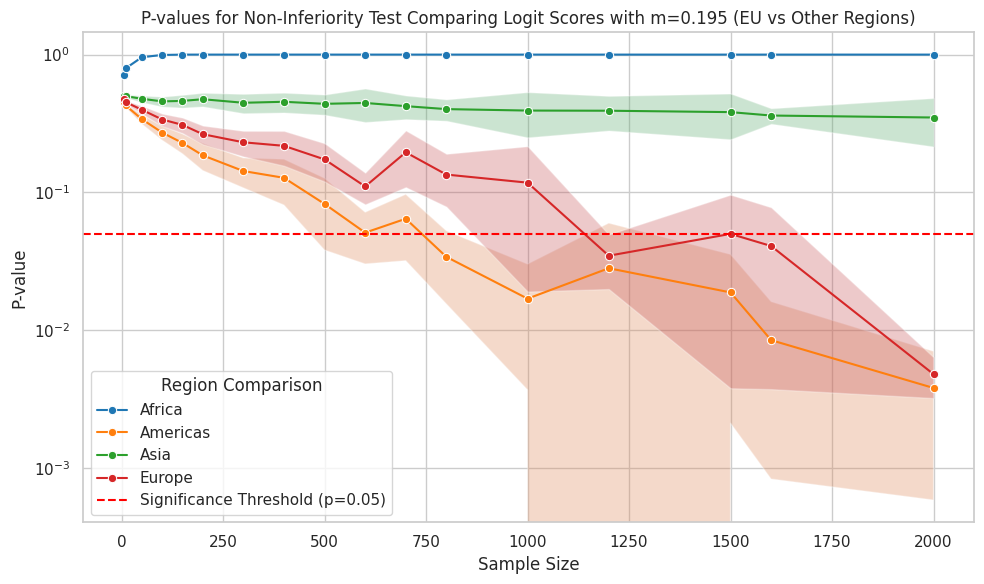

In [42]:
# Select one of the DataFrames to plot
df = df_log  # or df_conf
name = f"Logit Scores with m={log_margin:.3f}"

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(id_vars=['sample_size', 'fold'], 
                    value_vars=['p-value Asia', 'p-value Europe', 'p-value Africa', 'p-value Americas'],
                    var_name='Comparison', value_name='p-value')

# Rename columns for better readability in the plot
df_melted['Comparison'] = df_melted['Comparison'].replace({
    'p-value Asia': 'Asia',
    'p-value Europe': 'Europe',
    'p-value Africa': 'Africa',
    'p-value Americas': 'Americas'
})

# Group by sample size and comparison, then calculate mean and 95% CI, averaging over the folds
df_summary = df_melted.groupby(['sample_size', 'Comparison']).agg(
    p_value_mean=('p-value', 'mean'),      # Mean of p-values across folds
    p_value_std=('p-value', 'std'),        # Standard deviation of p-values across folds
    n=('p-value', 'size')                  # Number of folds for each sample_size and comparison
).reset_index()

# Calculate the 95% confidence intervals
df_summary['ci_upper'] = df_summary['p_value_mean'] + 1.96 * (df_summary['p_value_std'] / np.sqrt(df_summary['n']))
df_summary['ci_lower'] = df_summary['p_value_mean'] - 1.96 * (df_summary['p_value_std'] / np.sqrt(df_summary['n']))

# Create the plot with means and confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_summary, x='sample_size', y='p_value_mean', hue='Comparison', marker='o', palette='tab10')

# Plot the confidence interval as a shaded region
for comparison in df_summary['Comparison'].unique():
    subset = df_summary[df_summary['Comparison'] == comparison]
    plt.fill_between(subset['sample_size'], subset['ci_lower'], subset['ci_upper'], alpha=0.3)

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title(f'P-values for Non-Inferiority Test Comparing {name} (EU vs Other Regions)')
plt.xlabel('Sample Size')
plt.ylabel('P-value')
plt.yscale('log')  # Optional: Use logarithmic scale for p-values
plt.legend(title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()
